This Note book is an example implementation of IQCELL in early blood diffrentiation, ref(https://doi.org/10.1182/blood-2016-05-716480)

Using:
IQCELL V.1.1.0

### 1. loading the libraries, including iQcell package
First, we import iqcell package (make sure you have installed the required packages). Also, we will import ```matplotlib``` and ```pandas``` as well: 

In [1]:
import matplotlib as plt
import pandas as pd
import iqcell

HI
iqcell successfully imported


Below is the address directory of all input and output files, this can be ignored for now, but you can use it as a reference point:

In [2]:
# all shared adressed:
#eventually will be written in a file in iqcell folder, or in init file

#input files
Data_add='in_out/1_exoression_data.csv'
PT_address='in_out/1_PT_celltimes_sling.csv'
experimentals_GRN_add='in_out/1_Litrature_interactions.csv'
refrence_profile_add='in_out/1_reference_profiles.csv'
Tfs_list_add='in_out/1_Trancription_Factors.txt'

The addresses listed below are for internal refrences 

In [3]:
# internal IQCELL address book
#expression_recovery intermediate outputs:
expression_add_magic='in_out/2_magic_expression.csv'

# gene_selection intermediate outputs:
expression_add='in_out/3_exoression_data_genes_selected.csv'

#gene_interaction intermediate outputs:
interaction_add='in_out/4_gene_interactions.txt'

#expression_discretization intermediate outputs:
Descritized_exoression='in_out/5_Descritized_exoression.csv'

#gene_hierarchy intermediate outputs
file_base_z3='in_out/z3files/'
monocole_all_cells_z3_add='in_out/z3files/z3_cellorder.txt'
z3_expression_add='in_out/z3files/z3_expression.txt'
z3_command_line_add='in_out/z3files/z3_command_line.txt'
z3_interaction_add='in_out/z3files/z3_interaction.txt'

#model_selection intermediate outputs
GRN_file_address='in_out/8_GRN.txt'
ABN_GRN_file_address='in_out/8_GRN_ABN.txt'

# boolean_simulation intermediate outputs:
initial_condition_='in_out/9_initial_cnd.txt'
initial_condition_perturbations='in_out/9_initial_cnd_pertirbaion.txt'

input_graph_add='in_out/ABNfiles/9.1_output.gml'
metricsOutput_add='in_out/ABNfiles/9.2_metricsOutput.csv'
profilesOutput_='in_out/ABNfiles/9.2_profilesOutput.csv'
node_data_address='in_out/ABNfiles/9.1_output_nodes.csv'


<br><br><br><br><br><br><br>

### 2. Expression recovery (data imputation) step
At this step, we use the MAGIC (van Dijk, et al 2017) algorithm to correct the data for dropout effects. This step takes advantage of the higher numbers of genes, this is why we prefer to first do the imputation and then select a final smaller gene subset.<br>
The expression recovery is implemented in ```expression_recovery``` module. To perform the expression recovery, we need to set a reasonable value for the connectivity parameter ```knn_value```, we found that between ```5``` to ```10``` works well:

<img style="float: left;" src="warning.png">
<br>
 <font size="3"> <span style="color:black";>set parameter</span> </font>

| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| knn_value      | 10       | connectivity parameter   |

In [75]:
knn_value=10
# it runs expression recovery based on the given knn value and writes the results as 2_magic_expression.csv
emt_magic,magic_op=iqcell.expression_recovery.run_magic_and_write_data(Data_add,knn_value,expression_add_magic)
## emt_data = scprep.io.load_csv(Data_add, cell_names=True)

Calculating MAGIC...
  Running MAGIC on 746 cells and 23769 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/tiamheydari/.local/lib/python3.7/site-packages/magic/magic.py:426: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  "Input matrix contains unexpressed genes. "


    Calculated PCA in 1.01 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 1.13 seconds.
  Running MAGIC with `solver='exact'` on 23769-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.09 seconds.
Calculated MAGIC in 1.28 seconds.


Now, we can check how the imputation worked out. To do so, we can select some genes and plot them against each other. As we see below, after imputation (magic) many expression levels with the zero value (dropped out) are now recovered.

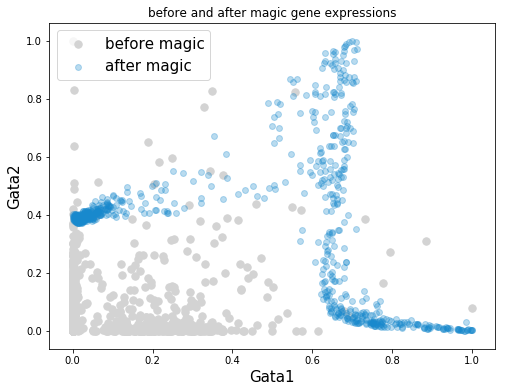

In [76]:
gene1='Gata1'
gene2='Gata2'
# this plots the expression relation between two genes, before and after the magic
Fig=iqcell.expression_recovery.plot_magic(gene1,gene2,knn_value,emt_magic,magic_op,Data_add,plot_DREMI=False)

A general tip: The figure is saved in the variable ```Fig```. You can save it to the ```plots``` folder as below. For other figures you can do the same, just change the name of the figure to your desired name. 

<br><br><br><br><br><br><br>

### 3. Selecting the final gene list for network inference:
You should select the final set of genes that will be used in the GRN inference. We recommend the number of genes to be less than ```20```. iQcell has some built-in tools that can assist with the gene selection procedure (see gene selection notebook). 

Below we insert the final list of genes of interest

In [13]:
# selecting genes this is the set of genes that we choosed:
Boolean_gene_list_final=['Fli1','Gata2','Spi1','Klf1','Gata1','Zbtb7a','Zfpm1']

<img style="float: left;" src="warning.png">
<br>
 <font size="3"> <span style="color:black";>select list of genes</span> </font>
    
| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| Boolean_gene_list_final      | -       | list of genes that will be used in the GRN    |

After selecting the genes, we will use ```export_selecet_genes``` to export them to the intermediate output file. 

In [78]:
# this experots the expression file for the selected genes as '3_exoression_data_genes_selected.csv'
iqcell.gene_selection.export_selecet_genes(expression_add_magic,Boolean_gene_list_final,expression_add,plot=False)

<br><br><br><br><br><br><br>

### 4. Calculating the gene-gene interaction score between all gene pairs
At this step, iQcell will calculate the interaction score (amount of mutual information) between gene pairs. If the user has introduced the optional file that lists the transcription factor genes ```1_Trancription_Factors.txt```, the iQcell uses this file and sets only the TFs as the genes that have the regulatory power (genes that can regulate other genes).  <br>
To do this we use ```gene_interaction``` module as below. It the TFs file is provided, we can inform iQcell by adding ```TFs_file_add=Tfs_list_add``` to the ```calculate_the_gene_gene_interaction_in_three_ways``` module, otherwise we can skip this and provide nothin as ```TFs_file_add``` . The calculated values are stored in new variables:<br>
```interaction_data```: list of gene interaction pairs<br>
```pearson_coeff```: the pearson value of gene correlation, will be used to assign sing to interactions <br>
```pearson_std```: the std of pearson correlations.<br>
```paritial_pearson_coeff```<br> 
```DREMI_SCORE```: The amount of mutual information<br>
```Figs```: Stores the figures

746
no TFs file is provided, all genes can interact
pearson


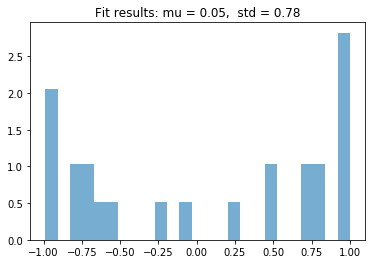

paritial pearson


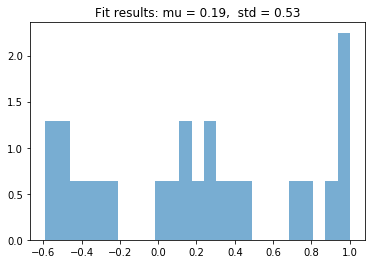

DREMI


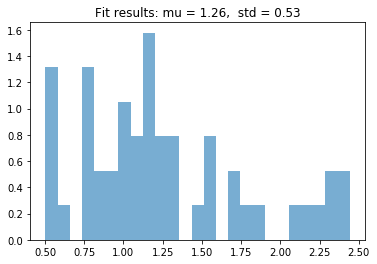

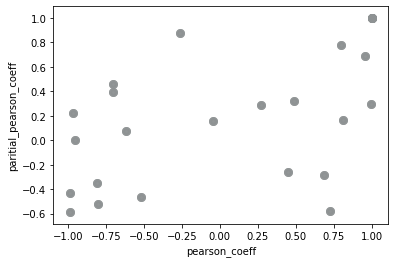

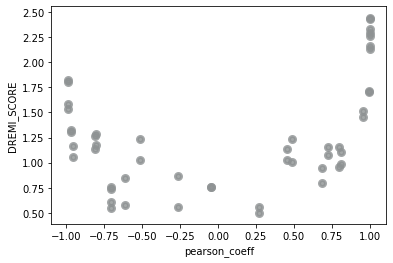

In [11]:
interaction_data,pearson_coeff,paritial_pearson_coeff,DREMI_SCORE,pearson_std, Figs=iqcell.gene_interaction.calculate_the_gene_gene_interaction_in_three_ways(expression_add)       

Next, we export the interactions to an intermediate output file. But first we can set a cutoff to delete the interactions that are difficult to assign a sign to. Note that sings (+/-)  are assigned based on Pearson correlation sing. Positive means genes are positively regulating each other and negative means one can repress the other<br>
<br>
<br>

<img style="float: left;" src="warning.png">
<br>
<font size="3"> <span style="color:black";>set parameter</span> </font>

| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| sign_threshold      | 0.7*pearson_std       |  the treshold to asing sign (+/-) to interactions    |

We can use the ```<calculate_sign_and_write_data``` function to to this.

In [80]:
# threshold to assigning a sing to the interaction: 
sign_threshold=0.65*pearson_std
iqcell.gene_interaction.calculate_sign_and_write_data(sign_threshold,interaction_data,pearson_coeff,paritial_pearson_coeff,DREMI_SCORE,interaction_add)


<br><br><br><br><br><br><br>

### 5.discretization of gene expression
iQcell required discretized (Boolean) expression level of genes to proceed further. To obtain this, we should convert expression levels (mRNA counts) to On/Off levels. iQcell has two possible built-in ways for discretization, based on the mean or the k-means clustering, the user can decide which one to use. The default model is k-means clustering. Since the calculation of clusters can be time-consuming, iQcell allows user to use a subset of cells (randomly selected), however, we suggest using the full number of cells:

<img style="float: left;" src="warning.png">
<br>
<font size="3"> <span style="color:black";>set parameter</span> </font>

| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| size_of_subset      | 250       |   size of subset of cells to calculte threshold   |

In [81]:
size_of_subset= len(pd.read_csv(PT_address)) # size of subset of cells to calculte threshold

Now that the parameters are set, we can calcute the descritization based on both methods, later we will pich one of out choice:

Mean method threshlding


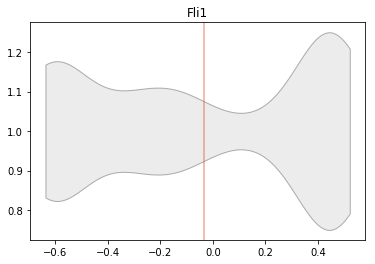

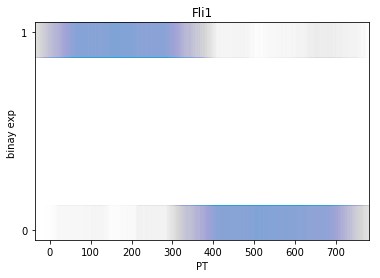

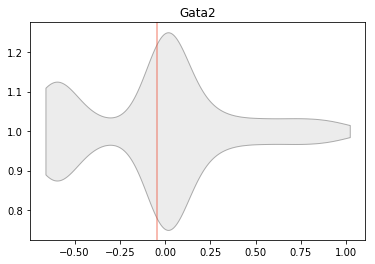

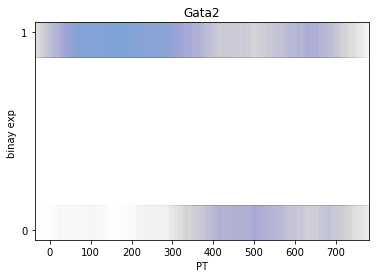

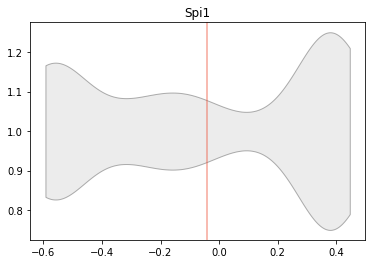

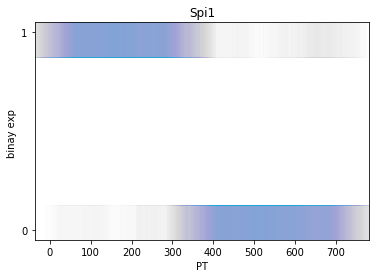

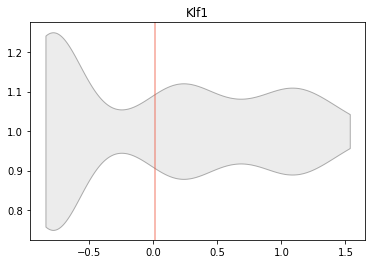

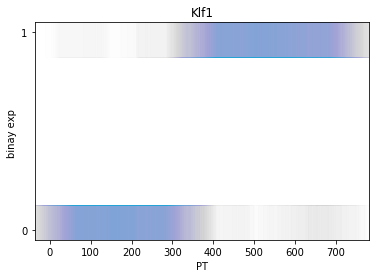

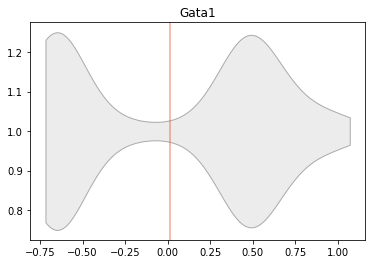

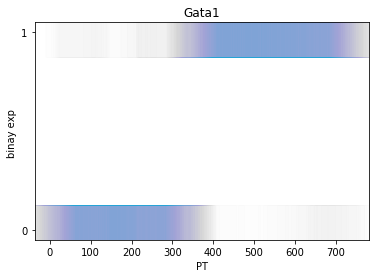

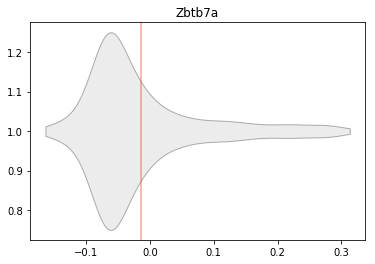

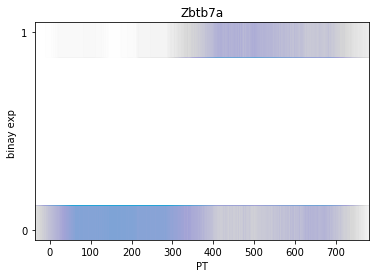

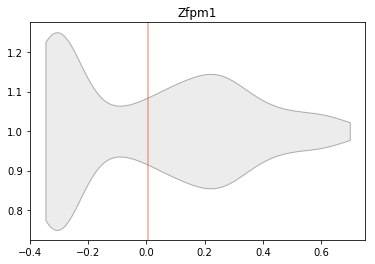

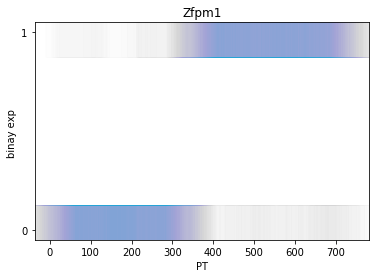

In [82]:
df_mean, Figs_mean=iqcell.expression_discretization.mean_thresholding_method_and_plot(expression_add,PT_address,
                                                                                     size_of_subset,plot=True)

K-mean method:

K-mean method threshlding


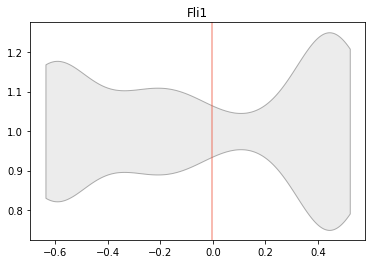

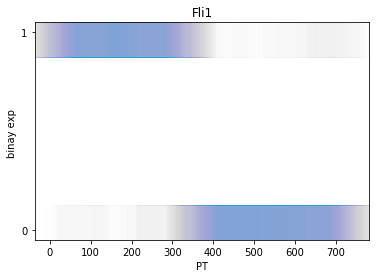

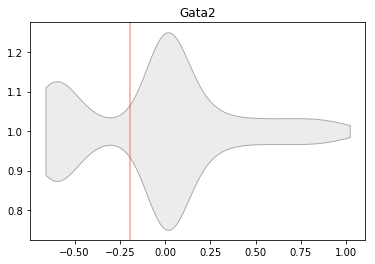

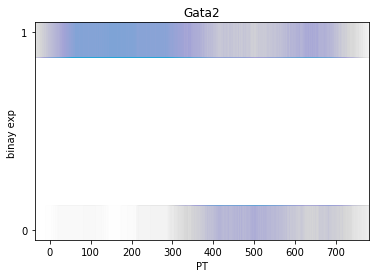

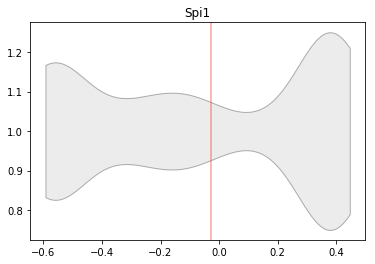

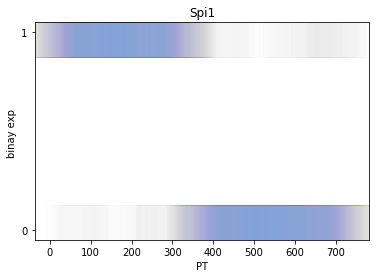

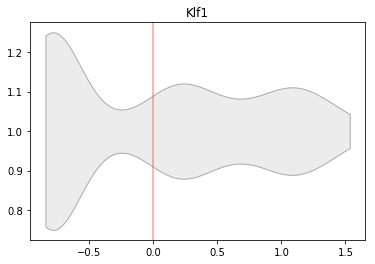

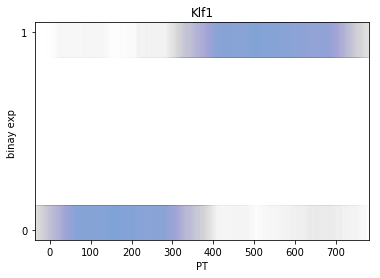

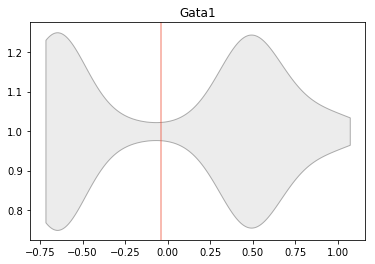

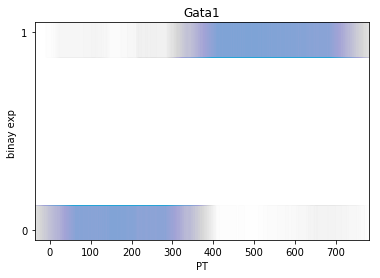

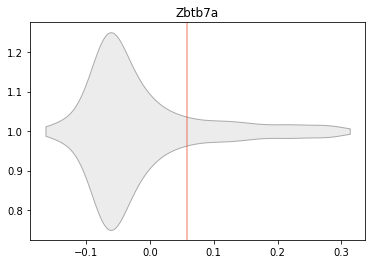

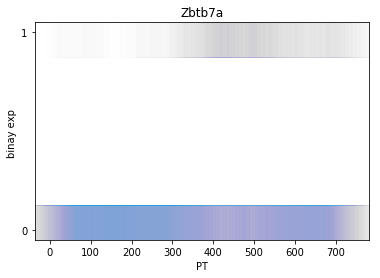

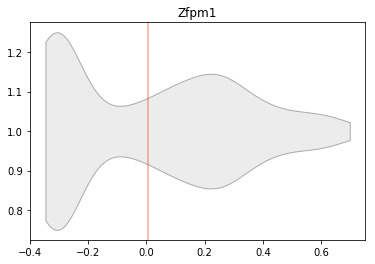

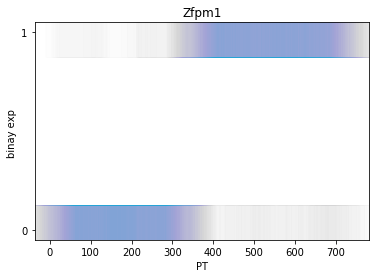

In [83]:
df_kmean, Figs_kmean=iqcell.expression_discretization.K_mean_thresholding_method_and_plot(expression_add,PT_address,
                                                                                    size_of_subset,plot=True)

Now we can plot the outcome of diffrent method, and choose the method of interest. k-means is the defualt method.

<img style="float: left;" src="warning.png">
<br>
<font size="3"> <span style="color:black";>set parameter</span> </font>

| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| Threshold_method      | 'K-means'       |   size of subset of cells to calculte threshold   |

In [84]:
Threshold_method='Mean' # either 'K-means' or 'Mean'
iqcell.expression_discretization.export_discretized_expression(Descritized_exoression,df_kmean,df_mean,Threshold_method)

<br><br><br><br><br><br><br>

### 6. forming the gene hierarchy and filtering some interactions
At this step, iQcell will form the gene hierarchy. The gene hierarchy is formed based on the transition of expression densities along the pseudo time. Gene with a sooner transition point (genes that change first along the pseudo time) will have more potential in the hierarchy and can regulate genes below them in the hierarchy.<br>
To do so, we need to set the parameters that the averaging window gets to calculate the transition point, you can keep the values to their default values for now.

<img style="float: left;" src="warning.png">
<br>
<font size="3"> <span style="color:black";>set parameter</span> </font>

| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| number_of_cells_z3      | 5000     |  The number of cells that will be sampled in the rest of the pipeline    |
| include_selfe_activation      | 'half'       |   size of subset of cells to calculte threshold   |
| include_selfe_activation     | False      |   if True, genes can activate themselves   |
| Window_size      | 100       |   the window size used in calculating expression density   |
| Percent_top      | 100      |    the percent of top interactions to be included    |
| jump_threshold_method      | 'median'      |    'kmeans' or 'mean' or 'median', method of calculating the treshold   |

In [4]:
number_of_cells_z3=len(pd.read_csv(PT_address))
include_selfe_activation=False
Window_size=100 # the window size used in calculating expression density
Percent_top= 100 # the percent of top interactions to be included !! note only signed one are included
jump_threshold_method='half'  #'kmeans' or 'mean' or 'median' or half  value

Now we can use the ```gene_hierarchy``` and its functions to start calculating transition point:

In [5]:
# 1___generating cell order file:
monocole_cells_z3=iqcell.gene_hierarchy.generating_cell_order(monocole_all_cells_z3_add,number_of_cells_z3,
                                                              PT_address)

# 2_____making the 'z3_expression.txt' file
expression_data_z3=iqcell.gene_hierarchy.generating_expression_file(Descritized_exoression,z3_expression_add,monocole_cells_z3)


# 3___calculing the possible gene gene iteractions based on scores and jumps
jump_thresholds=iqcell.gene_hierarchy.calculate_jump_thresholds_from_data(Window_size,
                                        expression_data_z3,monocole_cells_z3)

In [6]:
gene_jumps, genes_avraged_on_window, Figs =iqcell.gene_hierarchy.finding_gene_transition_points (jump_thresholds,
                                                                                        jump_threshold_method,Window_size,
                                                                                        expression_data_z3,monocole_cells_z3,
                                                                                        interaction_add,z3_interaction_add,
                                                                                        include_selfe_activation,Percent_top)


We can also check the transition points for genes by checking the saved figure:

next, we will do quality control for the Z3  step (boolean GRN inference) inputs with some plottings. First, we plot  the gene hierarchy based on transition (jump) times:

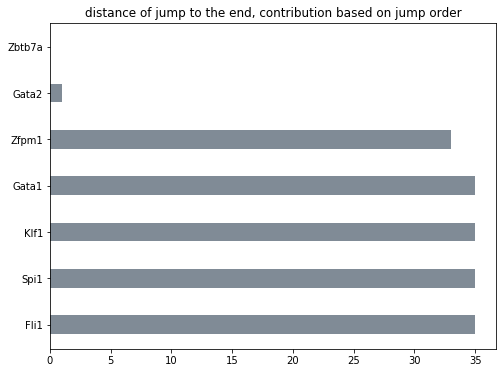

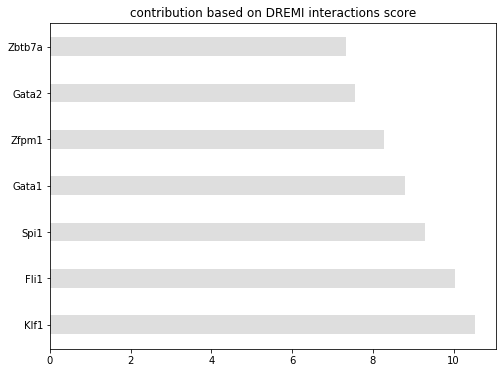

In [7]:
Fig=iqcell.gene_hierarchy.plot_gene_jump_order(gene_jumps,color='#808b96')
Fig=iqcell.gene_hierarchy.plot_gene_contribution_in_interactions_DREMI(interaction_add,gene_jumps,color='#dedede')

<img style="float: left;" src="warning.png">
<br>
<font size="3"> <span style="color:black";>Note! </span> </font>

Now we can plot how the descritized genes are expressing along the pseudo time for different genes:

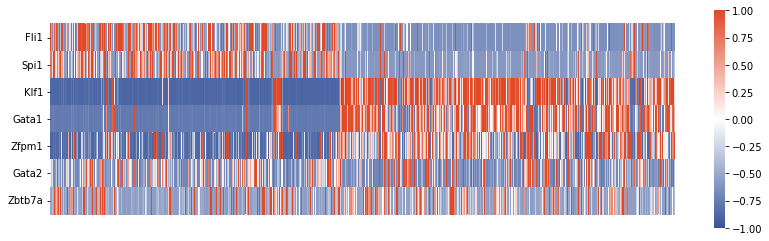

In [89]:
cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#355399",'white',"#e14a28"])
exprresion_along_PT, Fig=iqcell.gene_hierarchy.heat_map_plot_exprresion_along_PT(Data_add,PT_address,
                                                        gene_names_=list(gene_jumps.index),
                                                 sx=14,sy=4,cmap=cmap,vmin=-1,vmax=1)


In [90]:
#Fig.savefig("plots/1.png", bbox_inches='tight')

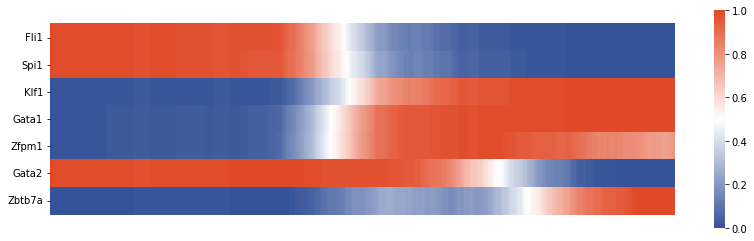

In [91]:
cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#355399",'white',"#e14a28"])
avrages_on_window, Fig=iqcell.gene_hierarchy.heatmap_avraging_expression_over_window_along_PT(expression_data_add='in_out/5_Descritized_exoression.csv',
                                                                          gene_names_=list(gene_jumps.index),Window_size=100, 
                                                                          monocole_cells_add=PT_address,
                                                                          number_of_ssamplpes=len(pd.read_csv(PT_address)),
                                                                          sx=14,sy=4,cmap=cmap,vmin=0,vmax=1)

In [92]:
#Fig.savefig("plots/2.png", bbox_inches='tight')

Given the plot above, we adjust the gene order, so the transition ponts (white lines), increase from top to bottom

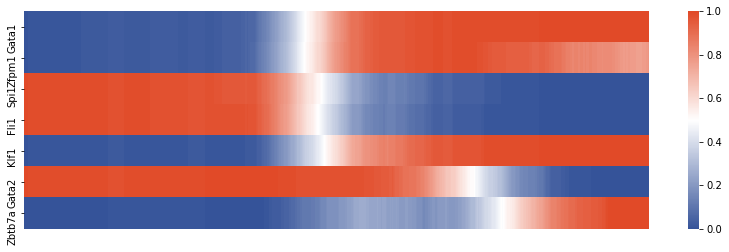

In [9]:
our_new_gene_order=['Gata1','Zfpm1','Spi1','Fli1','Klf1','Gata2','Zbtb7a']
gene_jumps=gene_jumps.loc[our_new_gene_order]

# plot to see:
cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#355399",'white',"#e14a28"])
avrages_on_window, Fig=iqcell.gene_hierarchy.heatmap_avraging_expression_over_window_along_PT(expression_data_add='in_out/5_Descritized_exoression.csv',
                                                                          gene_names_=list(gene_jumps.index),Window_size=100, 
                                                                          monocole_cells_add=PT_address,
                                                                          number_of_ssamplpes=len(pd.read_csv(PT_address)),
                                                                          sx=14,sy=4,cmap=cmap,vmin=0,vmax=1)

And also we can plot how gene density (averaged over the pseudo time window) is expressing along the pseudo time for different genes:

And finally, we can put all the pieces together and export and see the final interactions network that we obtained so far:

/anaconda3/envs/test/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/envs/test/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/anaconda3/envs/test/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


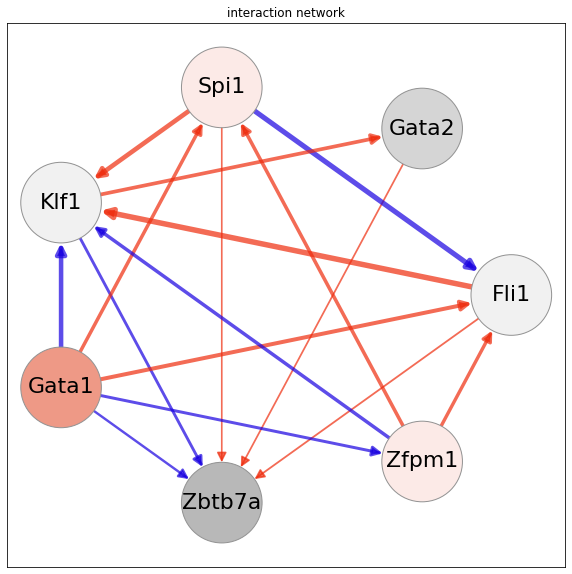

In [14]:
# threshold to assigning a sing to the interaction: 
sign_threshold=.66 *pearson_std
iqcell.gene_interaction.calculate_sign_and_write_data(sign_threshold,interaction_data,pearson_coeff,paritial_pearson_coeff,DREMI_SCORE,interaction_add)


iqcell.gene_hierarchy.export_z3_gene_interaction(z3_interaction_add,interaction_add,
                                                 include_selfe_activation,gene_jumps,Percent_top)


cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#808080",'white',"#e14a28"])
node_list, node_color, Fig=iqcell.gene_hierarchy.z3_draw_propsed_graph(z3_interaction_add,interaction_add,
                                                           z3_genes=Boolean_gene_list_final,im_size=10,
                                                           node_size=6500,font_size=22,arrowsize=20,arrow_width=3,
                                                           lable_font='black',edgecolors='#939393',color_map=cmap)

In [95]:
#Fig.savefig("plots/3_interaction_network.png", bbox_inches='tight')
#Fig.savefig("plots/3_interaction_network.pdf", bbox_inches='tight')

Below is an optional step, it allows users to run z3 GRN inference outside the iQcell and in the command line which is not recommended. To do so, you just need to copy-paste the commands in the ```z3_command_line.txt``` file in your terminal

<br><br><br><br><br><br><br>

### 7  Running Z3 and finding compatible rules:
Next iQcell uses the above interaction network to obtain a list of possible Boolean GRNs. This is done by using Z3 platform. We need to set some parameters for network inference and then run z3 for each gene independently. You can use the default parameter for now:

<img style="float: left;" src="warning.png">
<br>
<font size="3"> <span style="color:black";>set parameter</span> </font>

| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| step      | 100     |  the steps that uses to calculate network   |
| maxAct      | 4       |   the maximum number of activators for each gene   |
| maxRep      | 1      |   the maximum number of repressors for each gene   |
| threshold      | 0.95       |   the initial treshold of simulation vs experiment agreement   |
| thresholdStep      | 0.05      |   steps to decrease treshold    |
| recommended_number_of_jobs      | 3      |   number of jobs in multiproccessor inference   |

In [96]:
step = 100
maxAct = 4
maxRep = 2
threshold = 1
thresholdStep = 0.05
recommended_number_of_jobs=30 #int(mp.cpu_count())-1

In [97]:
gene_list_to_run=list(gene_jumps.loc[:,'gene'])
RL=gene_list_to_run[:]

In [98]:
iqcell.network_inference.check_z3_interactions(z3_interaction_add,gene_list_to_run,Descritized_exoression,PT_address)

PLEASE NOTE (Cautions): gene  Gata1  has no regulator: Please update the interaction selection steps or remove the gene
gene  Gata1  has no positive (+) regulator: Positive autoregulation has been added
gene  Spi1  has no positive (+) regulator: Positive autoregulation has been added
Spi1 is initially on, self activation added
Fli1 is initially on, self activation added
gene  Gata2  has no positive (+) regulator: Positive autoregulation has been added
Gata2 is initially on, self activation added


In [102]:
proccesses_list=iqcell.network_inference.Run_parallel_network_inference(RL,z3_expression_add,step,monocole_all_cells_z3_add,maxAct,maxRep,
                                         z3_interaction_add,threshold,thresholdStep)

Gata1  >>>Zfpm1Finding rules Gata1 
>>>Spi1  Gata1Fli1Finding rules Zfpm1 >>>
>>>  >>>  threshold is 1.000000 Zfpm1Finding rules Spi1Klf1
Finding rules Fli1 

>>>  >>> threshold is 1.000000 Fli1Spi1Gata2
Finding rules Klf1  >>>
  >>>>>> threshold is 1.000000  
Finding rules Gata2 threshold is 1.000000

Klf1 Gata2>>>  >>> threshold is 1.000000 
 threshold is 1.000000
Zbtb7a >>> Finding rules Zbtb7a
Zbtb7a >>>  threshold is 1.000000
Zfpm1 >>>  threshold is 0.950000
Gata2 >>>  threshold is 0.950000
Gata1 >>>  threshold is 0.950000
Fli1 >>>  threshold is 0.950000
Klf1 >>>  threshold is 0.950000
Spi1 >>>  threshold is 0.950000
Zbtb7a >>>  threshold is 0.950000
Zfpm1 >>>  threshold is 0.900000
Gata1 >>>  threshold is 0.900000
Gata2 >>>  threshold is 0.900000
Fli1 >>>  threshold is 0.900000
Klf1 >>>  threshold is 0.900000
Zbtb7a >>>  threshold is 0.900000
Spi1 >>>  threshold is 0.900000
Zfpm1 >>>  threshold is 0.850000
Gata1 >>>  threshold is 0.850000
Gata2 >>>  threshold is 0.850000
Fli1 >>>

In [33]:
#You can run below if you want to halt inference for gene, you can restart it later.

# gene_list_to_terminate=gene_list_to_run[:]
# iqcell.network_inference.terminate_parallel_network_inference(proccesses_list,gene_list_to_terminate)

### 8. Model selection 
The next step is model selection by using ```model_selection``` module. The previous step provided possible GRNs for the data, this step finds the one with the highest average mutual information between the genes.<br>
First, we need to convert the previous format to a more readable format: 

In [75]:
iqcell.model_selection.convert_z3_to_simbool (file_base_z3,Boolean_gene_list_final,z3_expression_add)

simbool files written at  in_out/z3files/


Next, we will run the ```select_model_GRN``` function to find the best model:

redundancy found in criteria of the best rule, one picked, diffrence is in the details of the boolean rules (AND/OR)
redundancy found in criteria of the best rule, one picked, diffrence is in the details of the boolean rules (AND/OR)
redundancy found in criteria of the best rule, one picked, diffrence is in the details of the boolean rules (AND/OR)
redundancy found in criteria of the best rule, one picked, diffrence is in the details of the boolean rules (AND/OR)
redundancy found in criteria of the best rule, one picked, diffrence is in the details of the boolean rules (AND/OR)


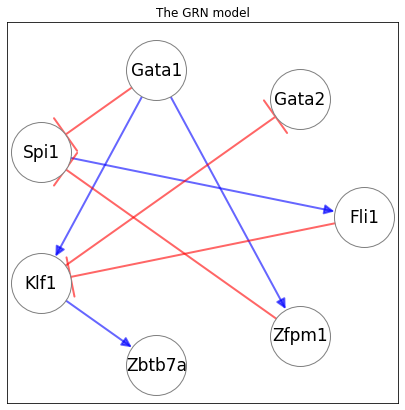

In [76]:
method_to_calculate_max_score='DREMI' # DREMI OR pearson
iqcell.model_selection.select_model_GRN(Boolean_gene_list_final,method_to_calculate_max_score,interaction_add,file_base_z3,GRN_file_address)
#Now we can visualize the candidate GRN for the data:
Network_best_GRN_z3, Fig=iqcell.model_selection.convert_GRN_to_networkx(interaction_add,GRN_file_address,im_size=7)



In [36]:
#Fig.savefig("plots/4_GRN.png", bbox_inches='tight')
#Fig.savefig("plots/4_GRN.pdf", bbox_inches='tight')

If we have the file that has known interactions ```1_Litrature_interactions.csv```, we can use the below line to compare the model GRN against the known interactions:

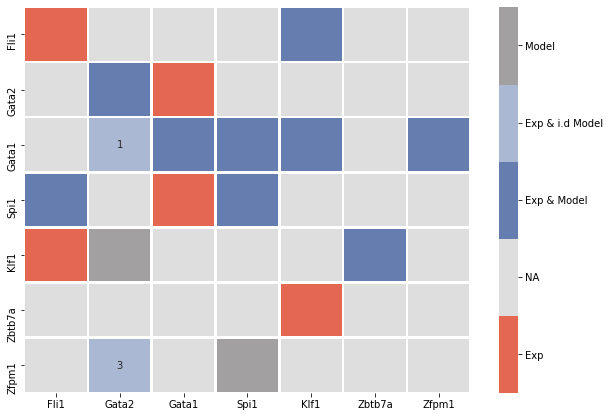

In [77]:
cmap=['#dedede',  # for NA
      '#a2a0a0',  # for Model
      '#667daf',  # for Exp & Mode
      '#aab8d3',  #for Exp & id Mode
      '#e46851' # for Exp
      ] 
Fig=iqcell.model_selection.compare_exp_vs_model_GRN(experimentals_GRN_add,cmap,Network_best_GRN_z3)

In [89]:
# Fig.savefig("plots/5_compare_interactions_with_known.png", bbox_inches='tight')
# Fig.savefig("plots/5_compare_interactions_with_known.pdf", bbox_inches='tight')

<br><br><br><br><br><br><br>

### 9. Boolean Network simulations and trajectory analysis
#### Boolean Simulation under the unperturbed condition
this section will run actual simulations on the candidate GRN and finds analyze its dynamics in different conditions.

<img style="float: left;" src="warning.png">
<br>
<font size="3"> <span style="color:black";>set parameter</span> </font>

| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| nruns_      | '--runs 200'     |  number of stochastic asynchronous simulation of GRNS   |
| steps_      |'--steps 20'      |   the time steps in the boolean simulation   |
| processes_      | '--processes 1'      |   the number of  processes at the time  |
| minSustainability_      | 0.7       |   the Sustainability value to calculate strongly connected component  |

In [78]:
#input files and parameters
#dint forget the space befor and afrer all parts
nruns_='--runs 50'
steps_='--steps 20'
processes_='--processes 1'
minSustainability_=0.5

Before running the simulations, we should indicate the initial state of the simulation. It means we should specify what genotype(s) the cells are initially. iQcell allows for manual input, but first, we can ask iQcell to find the initial cell states from discretized expression states of the cells with early pseudo-time value. It is done by averaging them state of each gene over the cells:

<img style="float: left;" src="warning.png">
<br>
<font size="3"> <span style="color:black";>set parameter</span> </font>

| parameter      | default value | Description     |
| :---        |    :----:   |          ---: |
| number_of_initial_cells      | 100     |  number of cells at the earlier pseudotime part to calculate initial state   |

Now we set initial conditions and make the boolean GRN ready for simulations

In [79]:
gene_order=list(gene_jumps.index)
number_of_initial_cells=int((len(pd.read_csv(PT_address)))/20)# number of cells with the earliest pt to considered as initial cells

# only in iqcell v1.1.0,  Initial_gene_states is exported as a dataframe
Initial_gene_states=iqcell.boolean_simulation.find_and_export_initial_states(number_of_initial_cells,initial_condition_,Descritized_exoression,PT_address)


# only in iqcell v1.1.0, Check_GRN_for_ABN_simulation exists.
iqcell.boolean_simulation.Check_GRN_for_ABN_simulation(interaction_add,GRN_file_address,gene_order,Initial_gene_states,ABN_GRN_file_address)




Gata1 is set to ture for ABN simulations


Now if needed, we can manually open the file ```initial_condition_``` with the address of ```in_out/9_initial_cnd.txt``` and edit it as we want.<br>
Now we will run the boolean simulation:

First test, if the rules are suitable for ABN simulations (the first gene- master regulator is ON at the beginin). If not correct it for simulations and make a new Rule's file. 

In [80]:
iqcell.boolean_simulation.simulate_Boolean_GRN(ABN_GRN_file_address,initial_condition_,input_graph_add,
                                               nruns_,steps_,processes_)

iqcell.boolean_simulation.read_run_analysis(minSustainability_,input_graph_add,metricsOutput_add,profilesOutput_)

targets, trajectoryDicts,attractor=iqcell.boolean_simulation.read_run_trajectory_analysis(node_data_address,input_graph_add)

#trajectoryDicts

Here we run the analysis on the attractors and GRN dynamics:

/Users/apple/Desktop/IQCELL_dec22_2021_allT_cell_Eryth_files/IQCELL_hammy_curated_genes_IQCELL_DEBUG/iqcell/boolean_simulation.py:652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Attrators_array_melt['value'][i]=off_color
/anaconda3/envs/test/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


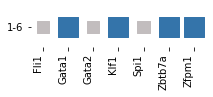

In [81]:
Fig=iqcell.boolean_simulation.plot_simunation_atractor_states(attractor,sx_factor=3.15,sy_factor=0.105,
     off_color='#c2bdbe',on_color='#3474aa',off_size=150,on_size=400,marker='s')

In [11]:
#Fig.savefig("plots/6_WT_attractors.png", bbox_inches='tight')
#Fig.savefig("plots/6_WT_attractors.pdf", bbox_inches='tight')

In [82]:
# based on the plot
attractor_of_interest_index=int(attractor.index[0])  # debug: some times the initial state in not the 0th element!!
mean_expres1sion_simulation, state_pt=iqcell.boolean_simulation.calculate_mean_std_of_trajs_to_attractor(attractor_of_interest_index,trajectoryDicts,
                                                                                               node_data_address,targets,export_State_pt=True)



In [43]:
# to make the order of genes similar to other heatmap plots of genes
#mean_expres1sion_simulation=mean_expres1sion_simulation.loc[:,our_new_gene_order]
#genes=['Notch1','Hes1','Lmo2','Tcf7','Myb','Hhex','Spi1','Runx1','Il7r','Gata3','Bcl11b','Tcf12','Ets1','Cd3g','Cd3e','Rag1','Lef1','Lyl1','Ptcra']
#mean_expres1sion_simulation=mean_expres1sion_simulation.loc[:,genes]

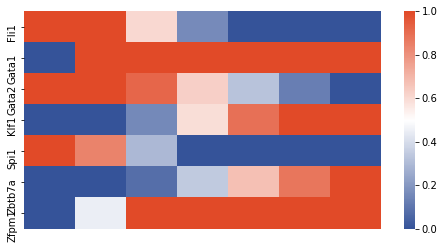

In [83]:
cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#355399",'white',"#e14a28"])
Fig=iqcell.boolean_simulation.plot_mean_mean_expression(mean_expres1sion_simulation,cmap=cmap)

In [45]:
#Fig.savefig("plots/9_WT_expression_dynamics.pdf", bbox_inches='tight')

['#000064', '#3c3c64', '#5b5b64', '#787864', '#9d9d64', '#c5c564', '#e14a28', '#c4c464', '#c4c464']


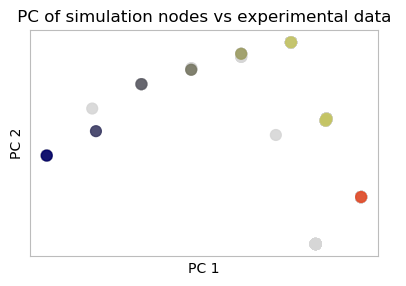

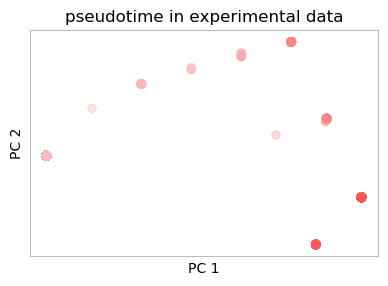

In [84]:

cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#355399",'white',"#e14a28"])
#cmap='bwr'
Fig=iqcell.boolean_simulation.PCA_compare_sims_vs_exps_overlay_Refrences(node_data_address,targets,z3_expression_add,
                                               PT_address,plot_PT=True,size_im=100,
                                                exp_color='#d6d6d6',sim_color='#6f6f6f'
                                               ,atractor_color='#e14a28' ,map_PT='bwr',refrence_point_color='gray',state_pt=list(state_pt))


In [47]:
# Fig[0].savefig("plots/7_PCA_WT.png", bbox_inches='tight')
# Fig[0].savefig("plots/7_PCA_WT.pdf", bbox_inches='tight')

# Fig[1].savefig("plots/8_PCA_PT.png", bbox_inches='tight')
# Fig[1].savefig("plots/8_PCA_PT.pdf", bbox_inches='tight')

In [85]:
# to make the order of genes similar to other heatmap plots of genes
mean_expres1sion_simulation=mean_expres1sion_simulation.loc[:,list(gene_jumps.index)]

In [25]:
# Fig.savefig("plots/9_attractor_comparison_litrature_WT.png", bbox_inches='tight')
# Fig.savefig("plots/9_attractor_comparison_litrature_WT.pdf", bbox_inches='tight')

print, initial conditions:

In [26]:
# Fig.savefig("plots/9initia_cond.pdf", bbox_inches='tight')

####  Boolean Simulation under the perturbed condition

##### Systematic KO

In [88]:
nruns_='--runs 10'
steps_='--steps 20'
attractor_along_experiments_perturb=pd.DataFrame()

Generating pertubrations automatically: 

Gata1*=False

Gata1_KO_


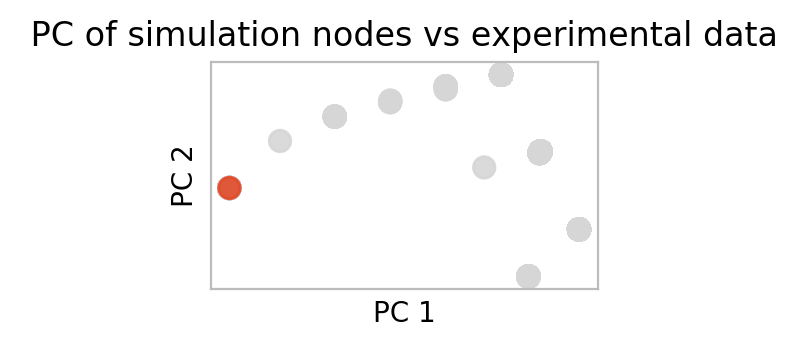

Zfpm1*=False

Zfpm1_KO_


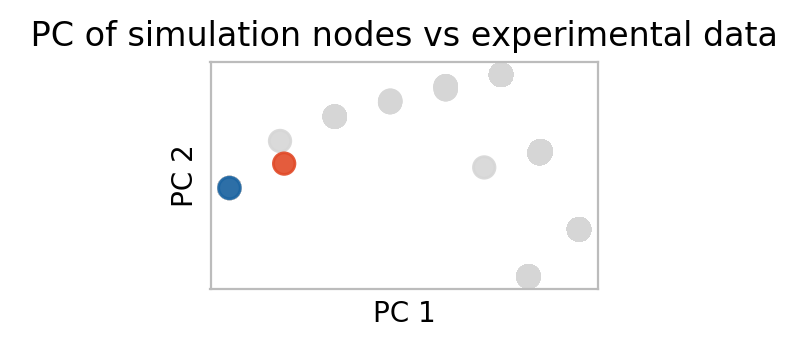

Spi1*=False

Spi1_KO_


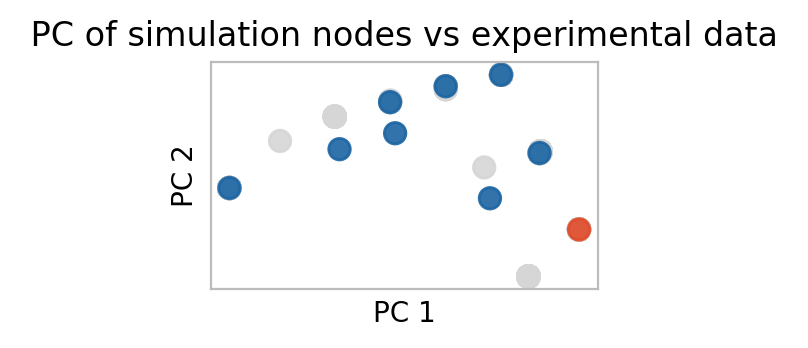

Fli1*=False

Fli1_KO_


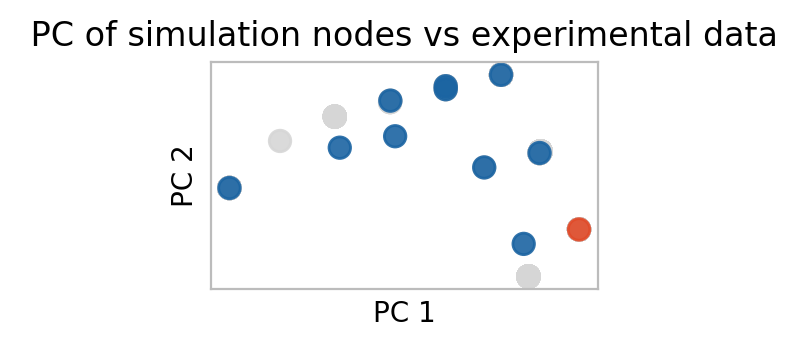

Klf1*=False

Klf1_KO_


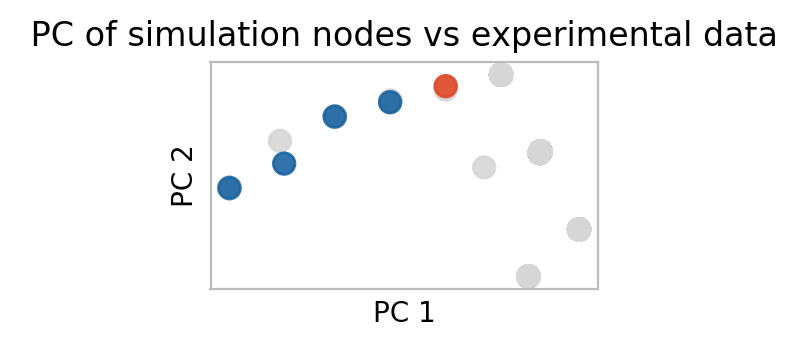

Gata2*=False

Gata2_KO_


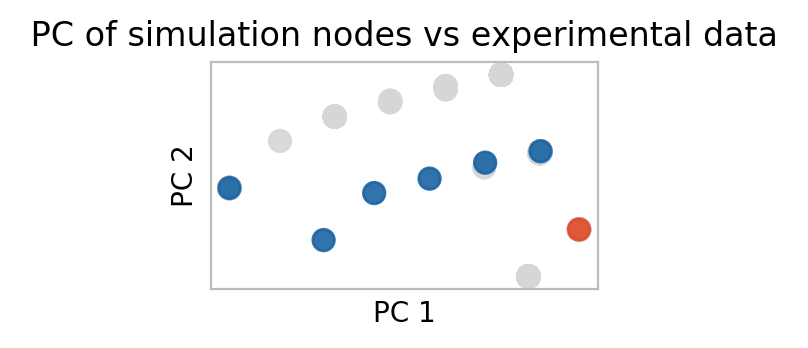

Zbtb7a*=False

Zbtb7a_KO_


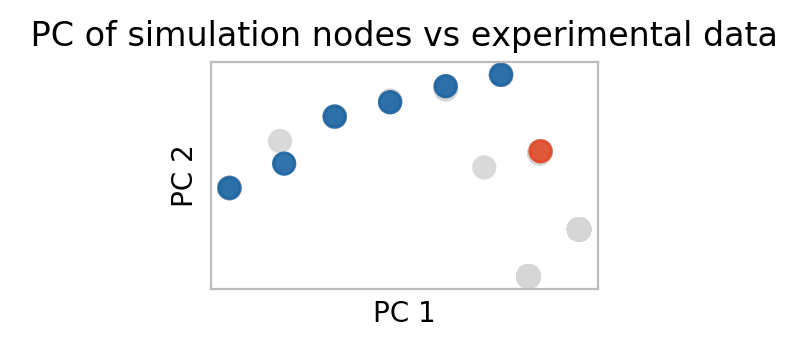

In [89]:
# definfn the perturbation condition
Perturbed_condition=[]
for g in list(our_new_gene_order):
    Perturbed_condition.append([[g],['KO']])
#Perturbed_condition.append([['Hes1'],['KO']])

attractor_along_experiments_perturb_KO, Figs=iqcell.boolean_simulation.run_gene_perturbations_simulations(
                    initial_condition_,ABN_GRN_file_address,nruns_,steps_,z3_expression_add,PT_address,
                    Perturbed_condition,sx=2.5,sy=1.5,exp_color='#d6d6d6',sim_color='#1b64a2'
                                    ,atractor_color='#e14a28' ,map_PT='Greys',refrence_point_color='yellow',plot=True)

Next, we analyze Perturbations and compare them with the experimental results. 

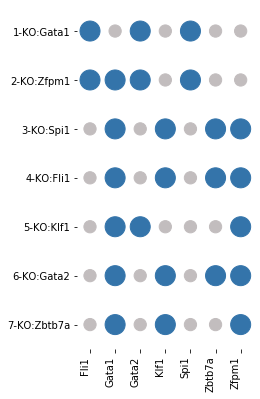

In [91]:
Fig_sys_KO=iqcell.boolean_simulation.plot_simunation_atractor_states(attractor_along_experiments_perturb_KO,
                                                              sx_factor=0.45,sy_factor=0.9,
                                                             off_color= '#c2bdbe',on_color='#3474aa'
                                                             ,off_size=150,on_size=400)


In [23]:
#Fig_sys_KO.savefig("plots/13_attractor_sys_KO.pdf", bbox_inches='tight')

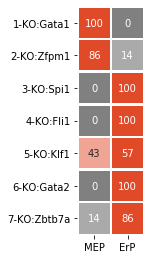

In [92]:
cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#808080",'white',"#e14a28"])
Fig, data=iqcell.boolean_simulation.Compare_simulation_states_with_refrence_states(attractor_along_experiments_perturb_KO,refrence_profile_add,
                                                                             sx_factor=0.6,sy_factor=0.6,cmap=cmap)

In [30]:
#Fig.savefig("plots/12_attractor_comparison_litrature_perturbation.pdf", bbox_inches='tight')
data.to_csv('in_out/ABNfiles/KO_to_refrence_comparison.csv')

#### Second round of pertubrations, systematic OE

Gata1*=True

Gata1_OE_


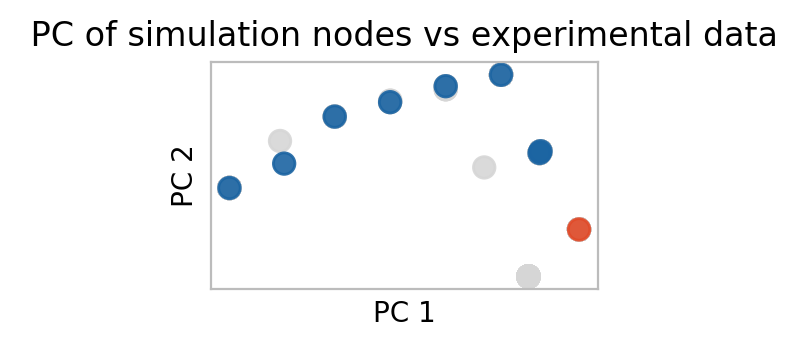

Zfpm1*=True

Zfpm1_OE_


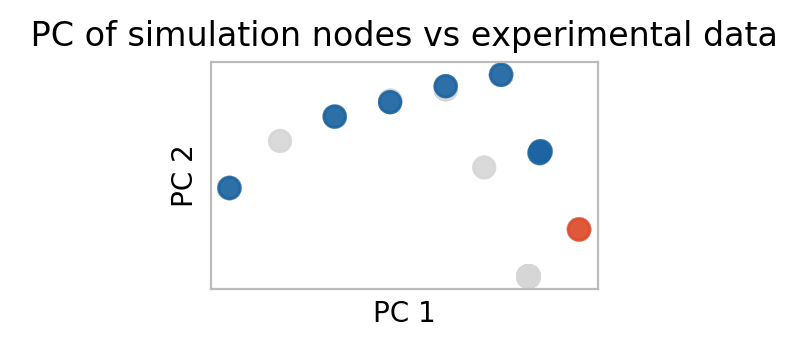

Spi1*=True

Spi1_OE_


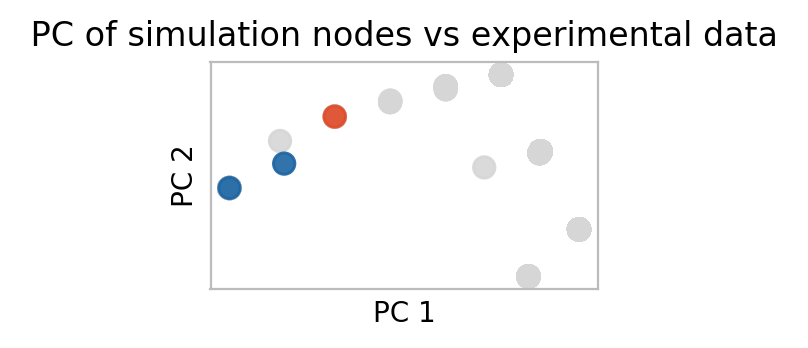

Fli1*=True

Fli1_OE_


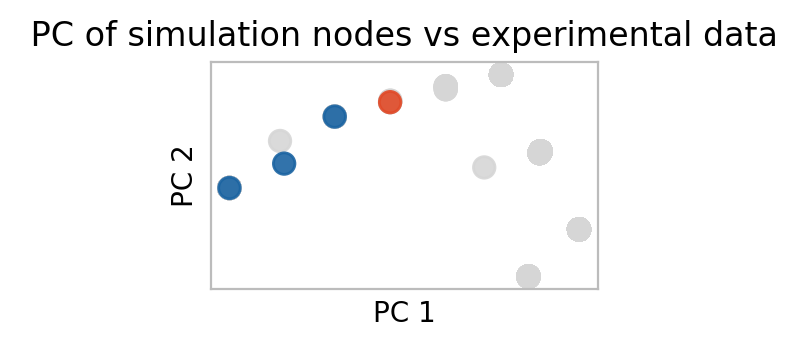

Klf1*=True

Klf1_OE_


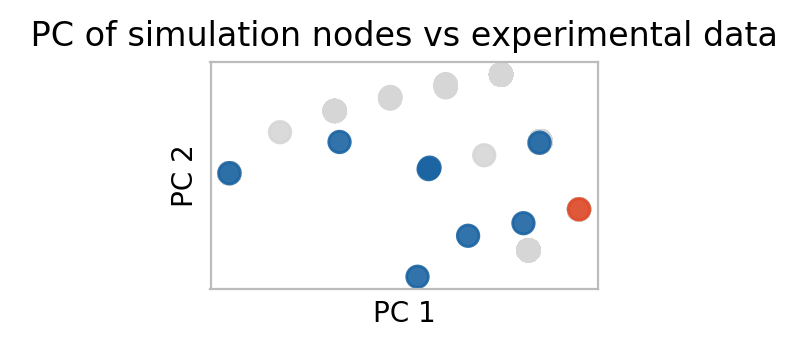

Gata2*=True

Gata2_OE_


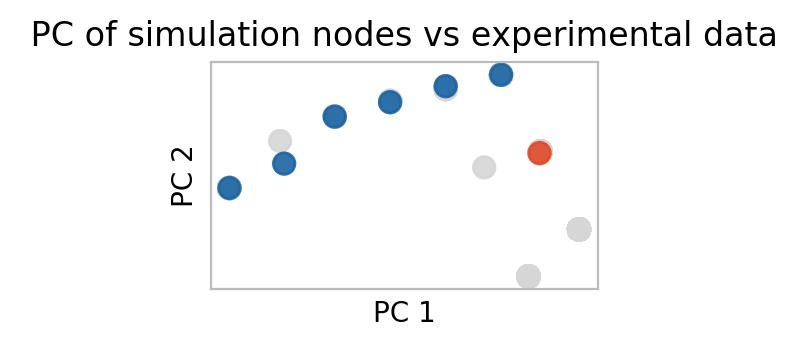

Zbtb7a*=True

Zbtb7a_OE_


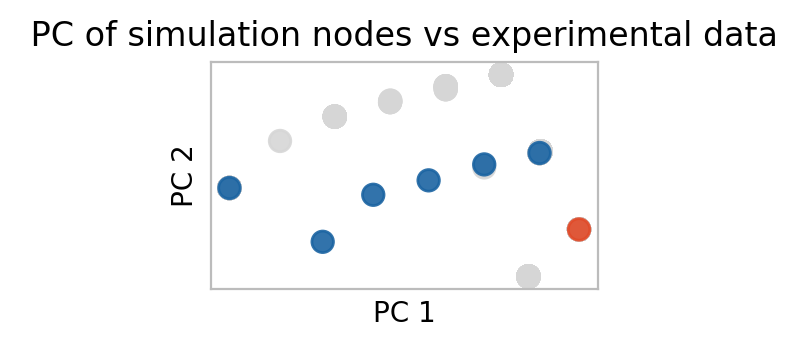

In [93]:
# definfn the perturbation condition
Perturbed_condition=[]
for g in list(our_new_gene_order):
    Perturbed_condition.append([[g],['OE']])
#Perturbed_condition.append([['Hes1'],['KO']])

attractor_along_experiments_perturb_OE, Figs=iqcell.boolean_simulation.run_gene_perturbations_simulations(
                    initial_condition_,ABN_GRN_file_address,nruns_,steps_,z3_expression_add,PT_address,
                    Perturbed_condition,sx=2.5,sy=1.5,exp_color='#d6d6d6',sim_color='#1b64a2'
                                    ,atractor_color='#e14a28' ,map_PT='Greys',refrence_point_color='yellow',plot=True)

/Users/apple/Desktop/IQCELL_dec22_2021_allT_cell_Eryth_files/IQCELL_hammy_curated_genes_IQCELL_DEBUG/iqcell/boolean_simulation.py:652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Attrators_array_melt['value'][i]=off_color
/anaconda3/envs/test/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


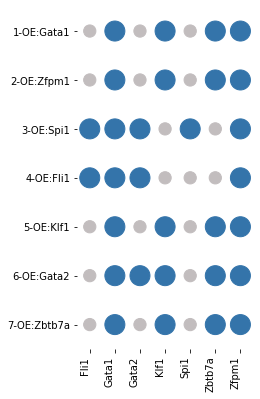

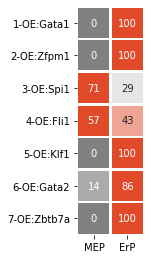

In [94]:
Fig_sys_OE=iqcell.boolean_simulation.plot_simunation_atractor_states(attractor_along_experiments_perturb_OE,
                                                             sx_factor=0.45,sy_factor=0.9,
                                                             off_color= '#c2bdbe',on_color='#3474aa'
                                                             ,off_size=150,on_size=400)

cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#808080",'white',"#e14a28"])
Fig, data=iqcell.boolean_simulation.Compare_simulation_states_with_refrence_states(attractor_along_experiments_perturb_OE,refrence_profile_add,
                                                                             sx_factor=0.6,sy_factor=0.6,cmap=cmap)

In [95]:
#Fig_sys_OE.savefig("plots/14_attractor_sys_OE.pdf", bbox_inches='tight')
#Fig.savefig("plots/12_attractor_comparison_litrature_perturbation_OE.pdf", bbox_inches='tight')
data.to_csv('in_out/ABNfiles/OE_to_refrence_comparison.csv')

## The end of the pipeline